In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

# Read the CSV file into a pandas DataFrame
concat_df = pd.read_csv(r"/home/student/GURUPRIYA/clean_concat.csv")

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the labels
concat_df['Label'] = label_encoder.fit_transform(concat_df['Label'])

# Suppose your features are stored in X and labels in y
X = concat_df.drop(columns=['Label'])  # Assuming 'Label' is the target column
y = concat_df['Label']

# Scale the features
scaler = MinMaxScaler()
scaledData = scaler.fit_transform(X)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the PCA-transformed data
pca_data = pd.read_csv(r"/home/student/GURUPRIYA/pca_transformed_data.csv")

# Extract features (X) from pca_data_df
X = pca_data
y = concat_df['Label']  # Labels



In [4]:
from sklearn.model_selection import train_test_split

# Assume X is your features data, and y is your labels data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

    # Define the hyperparameter distribution (e.g., for RBF kernel)
param_dist = {
        'C': loguniform(0.001, 100),
        'gamma': loguniform(0.001, 1),
        'kernel': ['rbf'] 
    }
    # Create the RandomizedSearchCV object without cross-validation
random_search = RandomizedSearchCV(
        SVC(),
        param_distributions=param_dist,
        n_iter=20,  # Number of iterations to search
        scoring='accuracy',
        n_jobs=-1,  # Use all available CPU cores for parallel processing
        random_state=42,
        cv=None  # No cross-validation, just use the provided train-test split
    )

In [ ]:
  # Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
best_params = random_search.best_params_
    
    # Create the SVM model with the best hyperparameters
best_model = SVC(kernel=best_params['kernel'], gamma=best_params['gamma'], C=best_params['C'])
    
    # Train the model on the entire training data
best_model.fit(X_train, y_train)
    

In [ ]:
 # Evaluate the model on the training and testing data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
    

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

# Predict the labels for the training and testing sets
y_train_pred_classes = y_train_pred
y_test_pred_classes = y_test_pred

# Generate classification reports for training and testing sets as dictionaries
train_report = classification_report(y_train, y_train_pred_classes, target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'], output_dict=True)
test_report = classification_report(y_test, y_test_pred_classes, target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'], output_dict=True)

# Calculate accuracy for each class in the training set
for stage in ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']:
    # Find class index
    class_index = list(train_report.keys()).index(stage)
    # Calculate accuracy
    correct_predictions = (y_train == class_index) & (y_train_pred_classes == class_index)
    accuracy = np.sum(correct_predictions) / np.sum(y_train == class_index)
    # Add accuracy to the report
    train_report[stage]['accuracy'] = accuracy

# Calculate accuracy for each class in the testing set
for stage in ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']:
    # Find class index
    class_index = list(test_report.keys()).index(stage)
    # Calculate accuracy
    correct_predictions = (y_test == class_index) & (y_test_pred_classes == class_index)
    accuracy = np.sum(correct_predictions) / np.sum(y_test == class_index)
    # Add accuracy to the report
    test_report[stage]['accuracy'] = accuracy

# Convert the classification reports to DataFrames
train_report_df = pd.DataFrame(train_report).T
test_report_df = pd.DataFrame(test_report).T

# Save the classification reports to CSV files
train_report_df.to_csv("train_report_svm_rbf_.csv")
test_report_df.to_csv("test_report_svm_rbf_.csv")

print("Saved the classification reports")


ROC curve saved to svm_rbf_roc_curve.svg


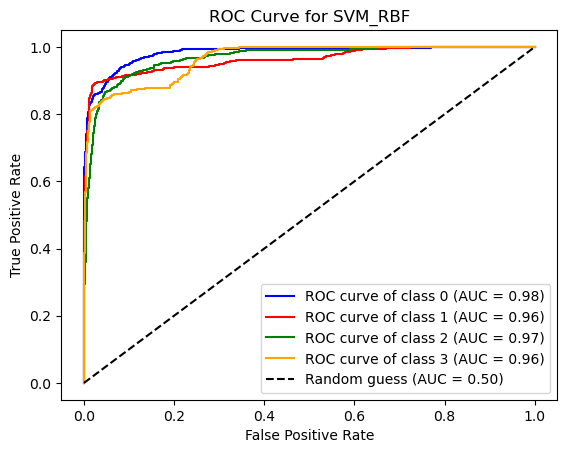

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Obtain decision scores on the test set
decision_scores = best_model.decision_function(X_test)

# Convert the test set labels to one-hot encoding
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust class values as needed

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], decision_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM_RBF')
plt.legend()

# Save the ROC curve as an SVG file
roc_curve_svg_path = 'svm_rbf_roc_curve.svg'  # Specify the file path and name
plt.savefig(roc_curve_svg_path, format='svg')
print(f"ROC curve saved to {roc_curve_svg_path}")


Learning curve saved to svm_rbf_learning_curve.svg


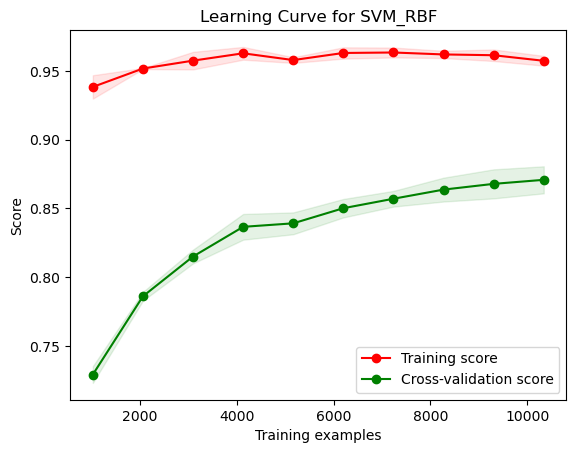

In [8]:
import numpy as np
from sklearn.model_selection import learning_curve

# Define the number of training examples at which to evaluate the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute learning curve
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=best_model,  # Replace 'best_model' with your SVM model
    X=X_train, 
    y=y_train, 
    train_sizes=train_sizes,
    cv=5,  # Number of folds in cross-validation
    scoring='accuracy'  # Evaluation metric
)

# Calculate mean and standard deviation of training scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of test scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve for SVM_RBF")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

# Save the learning curve as an SVG file
learning_curve_svg_path = 'svm_rbf_learning_curve.svg'  # Specify the file path and name
plt.savefig(learning_curve_svg_path, format='svg')
print(f"Learning curve saved to {learning_curve_svg_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define the number of training examples at which to evaluate the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute learning curve
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=best_model,  # Assuming 'best_model_linear' is your SVM linear model
    X=X_train, 
    y=y_train, 
    train_sizes=train_sizes,
    shuffle=True,  # Shuffle data before splitting
    random_state=42,  # Set random state for reproducibility
    scoring='accuracy',  # Evaluation metric
    return_times=False  # Do not return the training times
)

# Calculate mean of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Calculate mean of training and test loss
train_loss_mean = 1 - train_scores_mean
test_loss_mean = 1 - test_scores_mean

# Plot learning curve for accuracy and loss
plt.figure()
plt.title("Learning Curve for SVM RBF")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.plot(train_sizes_abs, train_loss_mean, 'o-', color="blue", linestyle='dotted',
         label="Training loss")
plt.plot(train_sizes_abs, test_loss_mean, 'o-', color="blue",
         label="Test loss")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="gold",
         label="Training accuracy")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="yellow", linestyle='dotted',
         label="Test accuracy")

plt.legend(loc="best")

# Save the learning curve as an SVG file
learning_curve_svg_path = 'svm_rbf_learning_curve_custom.svg'  # Specify the file path and name
plt.savefig(learning_curve_svg_path, format='svg')
print(f"Learning curve saved to {learning_curve_svg_path}")
